## 1. Introdução
Implementaremos a regressão linear utilizando a biblioteca autograd para calcular os gradientes.



Eu gostaria de prever o comportamento da ação PETR4 porque isso permite realizar operações lucrativas com antecedência

## 2. Coleta de Dados

In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad

# Definir o ticker da ação PETR4 e coletar dados históricos
ticker = 'PETR4.SA'
dados = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# Exibir as primeiras linhas dos dados
dados.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2020-01-02 00:00:00+00:00,10.621439,30.700001,30.700001,30.309999,30.510000,37774500
2020-01-03 00:00:00+00:00,10.534947,30.450001,31.240000,30.450001,30.879999,71595600
2020-01-06 00:00:00+00:00,10.659495,30.809999,30.940001,29.950001,30.430000,81844000
2020-01-07 00:00:00+00:00,10.617979,30.690001,30.879999,30.469999,30.820000,32822000
2020-01-08 00:00:00+00:00,10.552244,30.500000,30.770000,30.240000,30.690001,48215600


## 3. Análise e Pré-processamento dos Dados

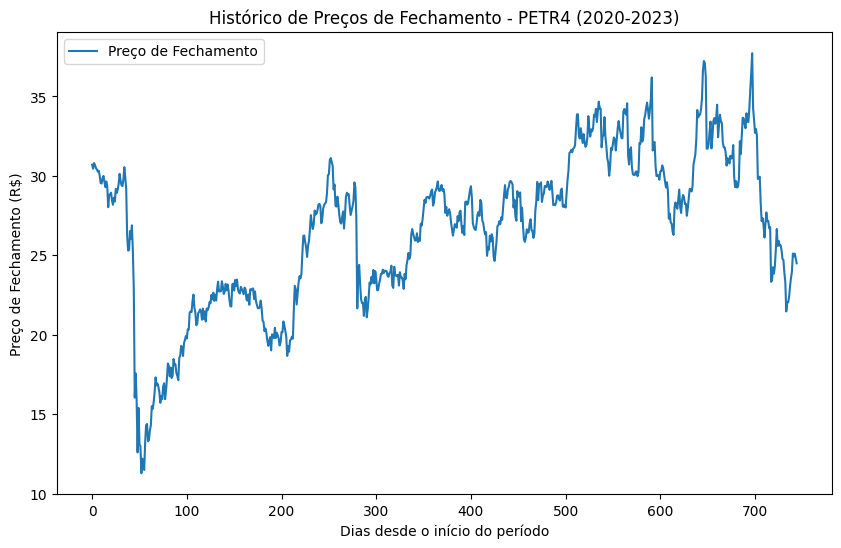

In [14]:
# Vamos focar no preço de fechamento ('Close'), e remover possíveis valores ausentes.
dados = dados[['Close']].dropna()

# Criar uma coluna para representar os dias (como variável independente)
dados['Days'] = range(len(dados))

# Visualizar os dados de fechamento da ação
plt.figure(figsize=(10,6))
plt.plot(dados['Days'], dados['Close'], label='Preço de Fechamento')
plt.title('Histórico de Preços de Fechamento - PETR4 (2020-2023)')
plt.xlabel('Dias desde o início do período')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()


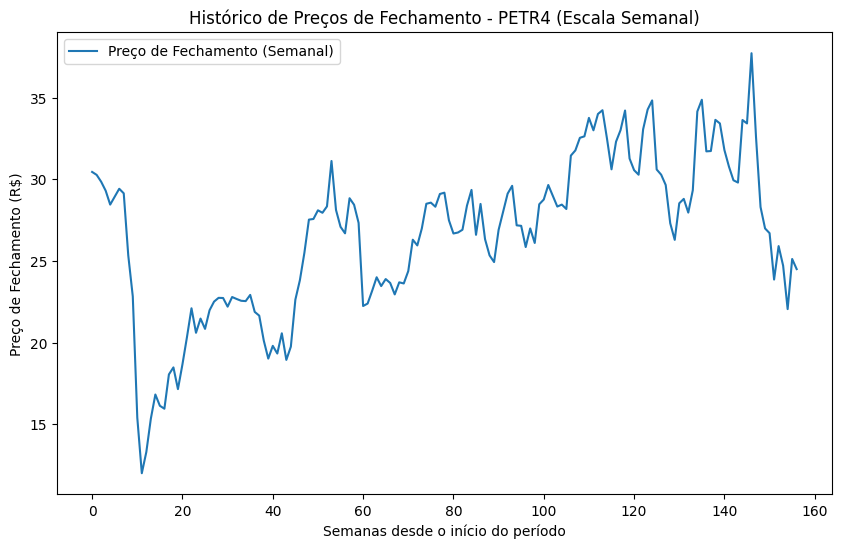

In [23]:
# Converter os dados diários para semanalmente (usando o último preço de fechamento da semana)
dados_semana = dados[['Close']].resample('W').last().dropna()

# Criar uma coluna para representar as semanas (como variável independente)
dados_semana['Weeks'] = range(len(dados_semana))

# Visualizar os dados semanais
plt.figure(figsize=(10,6))
plt.plot(dados_semana['Weeks'], dados_semana['Close'], label='Preço de Fechamento (Semanal)')
plt.title('Histórico de Preços de Fechamento - PETR4 (Escala Semanal)')
plt.xlabel('Semanas desde o início do período')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()


C:\Users\vinil\AppData\Local\Temp\ipykernel_17572\228946181.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dados_mes = dados[['Close']].resample('M').last().dropna()


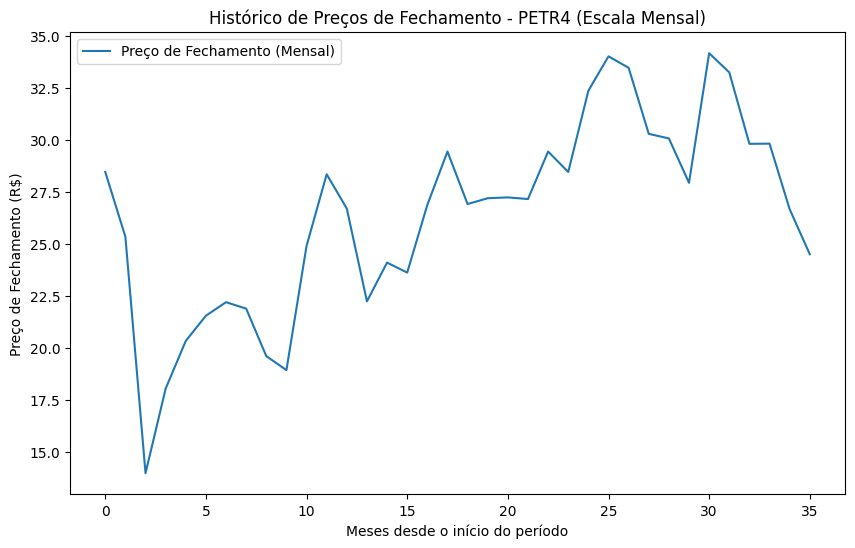

In [24]:
# Converter os dados diários para mensalmente (usando o último preço de fechamento do mês)
dados_mes = dados[['Close']].resample('M').last().dropna()

# Criar uma coluna para representar os meses (como variável independente)
dados_mes['Months'] = range(len(dados_mes))

# Visualizar os dados mensais
plt.figure(figsize=(10,6))
plt.plot(dados_mes['Months'], dados_mes['Close'], label='Preço de Fechamento (Mensal)')
plt.title('Histórico de Preços de Fechamento - PETR4 (Escala Mensal)')
plt.xlabel('Meses desde o início do período')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()


## 4. Divisão dos Dados em Treino e Teste

In [26]:
# Função para criar janelas deslizantes (k últimas observações como entrada)
def criar_janelas_deslizantes(dados, k):
    X, y = [], []
    for i in range(len(dados) - k):
        X.append(dados[i:i + k])  # Entradas: últimas k observações
        y.append(dados[i + k])    # Saída: próxima observação
    return np.asarray(X), np.asarray(y)

# Definir o número de valores anteriores (k) para prever o próximo valor
k = 3

# Criar janelas deslizantes para os dados de dias, semanas e meses
X, y = criar_janelas_deslizantes(dados['Close'].values, k)
X1, y1 = criar_janelas_deslizantes(dados_semana['Close'].values, k)
X3, y3 = criar_janelas_deslizantes(dados_mes['Close'].values, k)

# Dividir os dados de dias em treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Dividir os dados de semanas em treino e teste (70% treino, 30% teste)
split_idx1 = int(0.7 * len(X1))
X1_train, X1_test = X1[:split_idx1], X1[split_idx1:]
y1_train, y1_test = y1[:split_idx1], y1[split_idx1:]

# Dividir os dados de meses em treino e teste (70% treino, 30% teste)
split_idx3 = int(0.7 * len(X3))
X3_train, X3_test = X3[:split_idx3], X3[split_idx3:]
y3_train, y3_test = y3[:split_idx3], y3[split_idx3:]


## 5. Implementação da Regressão Linear com autograd

In [27]:
# Função de modelo linear corrigida
def modelo_linear(params, X):
    W, b = params
    X = np.squeeze(X)
    return np.dot(X, W) + b

# Função de custo
def custo(params, X, y):
    previsao = modelo_linear(params, X)
    erro = previsao - y
    return np.mean(erro**2)

# Gradiente da função de custo
grad_custo = grad(custo)

# Função para treinar o modelo e retornar os parâmetros
def treinar_modelo(X_train, y_train, taxa_aprendizado=0.0001, n_iteracoes=10000):
    # Padronização dos dados
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std

    y_train_mean = np.mean(y_train)
    y_train_std = np.std(y_train)
    y_train = (y_train - y_train_mean) / y_train_std

    y_train = np.squeeze(y_train)

    # Inicialização dos parâmetros
    n_caracteristicas = X_train.shape[1]
    W = np.random.randn(n_caracteristicas)
    b = np.random.randn(1)
    params = [W, b]

    # Treinamento
    for i in range(n_iteracoes):
        gradientes = grad_custo(params, X_train, y_train)
        params[0] -= taxa_aprendizado * gradientes[0]
        params[1] -= taxa_aprendizado * gradientes[1]
        if i % 1000 == 0:
            print(f"Iteração {i}: Custo = {custo(params, X_train, y_train)}")
    
    return params, X_train_mean, X_train_std, y_train_mean, y_train_std

# Treinamento para dias, semanas e meses
params_dia, X_train_mean, X_train_std, y_train_mean, y_train_std = treinar_modelo(X_train, y_train)
params_semana, X1_train_mean, X1_train_std, y1_train_mean, y1_train_std = treinar_modelo(X1_train, y1_train)
params_mes, X3_train_mean, X3_train_std, y3_train_mean, y3_train_std = treinar_modelo(X3_train, y3_train)


Iteração 0: Custo = 1.3939801048490583
Iteração 1000: Custo = 0.6205966776570511
Iteração 2000: Custo = 0.333236886967078
Iteração 3000: Custo = 0.21129457893212983
Iteração 4000: Custo = 0.1511562247418465
Iteração 5000: Custo = 0.11742684843361993
Iteração 6000: Custo = 0.09680356422071765
Iteração 7000: Custo = 0.08355896714395926
Iteração 8000: Custo = 0.07483006021495954
Iteração 9000: Custo = 0.0689964886434528
Iteração 0: Custo = 0.15727631868137346
Iteração 1000: Custo = 0.14382602102112432
Iteração 2000: Custo = 0.1383352255165261
Iteração 3000: Custo = 0.13562472837777104
Iteração 4000: Custo = 0.1339562283308087
Iteração 5000: Custo = 0.13272873002040872
Iteração 6000: Custo = 0.13172260498000948
Iteração 7000: Custo = 0.13084974008197195
Iteração 8000: Custo = 0.13006976676805748
Iteração 9000: Custo = 0.12936118596928659
Iteração 0: Custo = 5.552377266682773
Iteração 1000: Custo = 3.4953113816059873
Iteração 2000: Custo = 2.3390891326855816
Iteração 3000: Custo = 1.6505624

## 6. Avaliação do Modelo

In [28]:
# Função para avaliar o modelo
def avaliar_modelo(params, X_test, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std):
    X_test = np.squeeze(X_test)
    X_train_mean = np.squeeze(X_train_mean)
    X_train_std = np.squeeze(X_train_std)

    # Normalizar X_test e y_test
    X_test = (X_test - X_train_mean) / X_train_std
    y_test = (y_test - y_train_mean) / y_train_std

    # Fazer previsões
    y_pred = modelo_linear(params, X_test)

    # Desnormalizar
    y_pred = y_pred * y_train_std + y_train_mean
    y_test = np.squeeze(y_test) * y_train_std + y_train_mean

    # Cálculo do Erro Médio Absoluto (MAE) e Erro Quadrático Médio (MSE)
    mae = np.mean(np.abs(y_test - y_pred))
    mse = np.mean((y_test - y_pred)**2)

    return mae, mse, y_pred, y_test

# Avaliar para dias
mae_dia, mse_dia, y_pred_dia, y_test_dia = avaliar_modelo(params_dia, X_test, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std)

# Avaliar para semanas
mae_semana, mse_semana, y_pred_semana, y1_test_semana = avaliar_modelo(params_semana, X1_test, y1_test, X1_train_mean, X1_train_std, y1_train_mean, y1_train_std)

# Avaliar para meses
mae_mes, mse_mes, y_pred_mes, y3_test_mes = avaliar_modelo(params_mes, X3_test, y3_test, X3_train_mean, X3_train_std, y3_train_mean, y3_train_std)

print(f"MAE (Dias): {mae_dia:.2f}, MSE (Dias): {mse_dia:.2f}")
print(f"MAE (Semanas): {mae_semana:.2f}, MSE (Semanas): {mse_semana:.2f}")
print(f"MAE (Meses): {mae_mes:.2f}, MSE (Meses): {mse_mes:.2f}")


MAE (Dias): 1.07, MSE (Dias): 1.93
MAE (Semanas): 1.64, MSE (Semanas): 4.42
MAE (Meses): 2.45, MSE (Meses): 8.62


## 7. Visualização dos Resultados

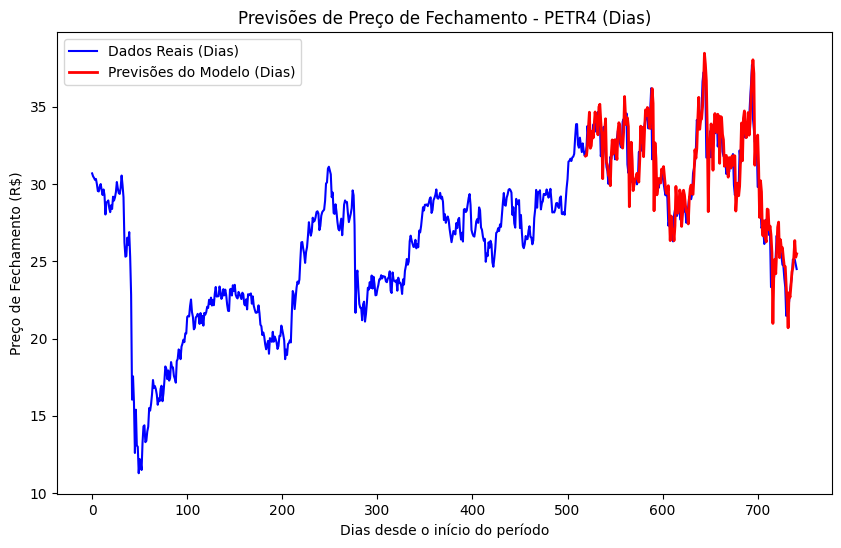

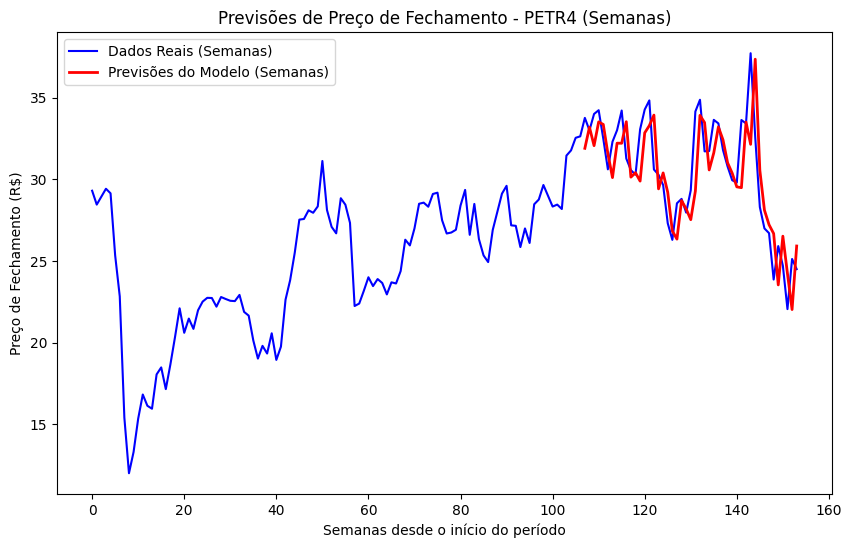

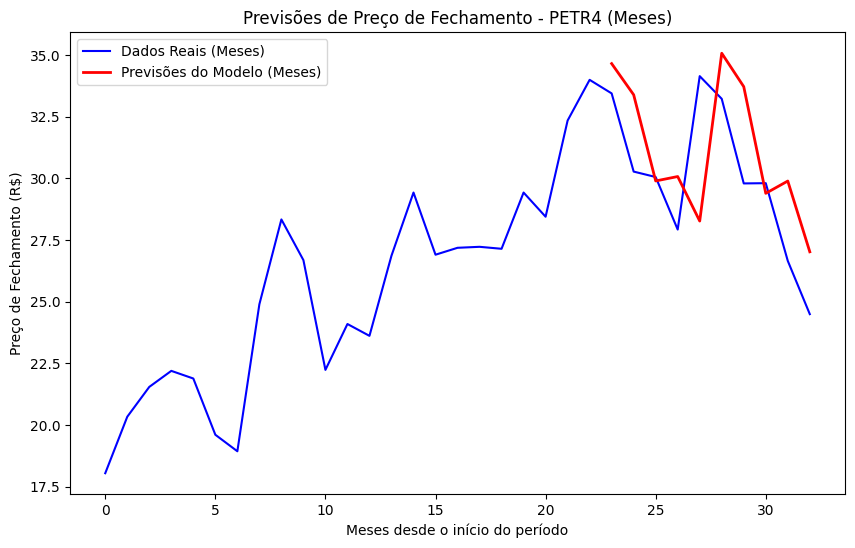

In [29]:
# Função para plotar os resultados
def plotar_resultados(y, y_pred, tamanho_treino, escala):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y)), y, color='blue', label=f'Dados Reais ({escala})')
    plt.plot(range(tamanho_treino, len(y)), y_pred, color='red', linewidth=2, label=f'Previsões do Modelo ({escala})')
    plt.title(f'Previsões de Preço de Fechamento - PETR4 ({escala})')
    plt.xlabel(f'{escala} desde o início do período')
    plt.ylabel('Preço de Fechamento (R$)')
    plt.legend()
    plt.show()

# Plotar para dias
plotar_resultados(y, y_pred_dia, split_idx, 'Dias')

# Plotar para semanas
plotar_resultados(y1, y_pred_semana, split_idx1, 'Semanas')

# Plotar para meses
plotar_resultados(y3, y_pred_mes, split_idx3, 'Meses')


## 8. Conclusão
Comparação dos Resultados com o Artigo
No artigo "Cryptocurrency Price Prediction Using Linear Regression and Long Short-Term Memory (LSTM)", os autores utilizaram tanto a regressão linear quanto o modelo LSTM para prever tendências de preços. Eles observaram que, embora a regressão linear fosse capaz de identificar algumas tendências, ela não conseguia capturar de maneira eficaz mudanças complexas e dinâmicas nos preços, especialmente devido à alta volatilidade característica das criptomoedas. No nosso caso, os resultados obtidos para a ação PETR4 mostraram previsões mais estáveis, o que provavelmente se deve à menor volatilidade de ações tradicionais em comparação com criptomoedas.

Discussão sobre a Viabilidade da Regressão Linear
A regressão linear, de maneira geral, é uma ferramenta útil quando há uma relação linear clara entre as variáveis independentes (como o tempo) e a variável dependente (preço de fechamento). No entanto, durante o desenvolvimento do nosso projeto, percebemos algumas limitações deste modelo, especialmente em situações onde:

Há alta volatilidade nos dados, o que não é tão presente no caso da PETR4, mas ainda assim há flutuações que o modelo linear não capturou tão bem.
Existem influências complexas e não-lineares nos preços, que a regressão linear não é capaz de modelar.
Fatores externos, como mudanças macroeconômicas, decisões políticas ou eventos inesperados, que não podem ser diretamente modelados apenas pelo tempo.
Com base nos resultados obtidos, a regressão linear funcionou de forma satisfatória para capturar a tendência geral dos preços da PETR4, especialmente quando analisamos em escalas de tempo maiores (semanas e meses). No entanto, o modelo não foi suficientemente preciso para capturar variações mais sutis ou oscilações bruscas no curto prazo. A partir dessas observações, consideramos que a regressão linear é viável para identificar tendências gerais, mas que o uso de modelos mais avançados, como o LSTM sugerido no artigo, poderia melhorar significativamente o desempenho das previsões, principalmente ao lidar com dinâmicas mais complexas dos dados.4.